# CIFAR10 example with ResNet56

This example demonstrates the usage of `LRFinder` with a ResNet56 on the Cifar10 dataset.

In [1]:
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import cifar10_resnet as rc10

import sys
sys.path.append('..')
from lr_finder import LRFinder

/home/davidtvs/datascience/pytorch/pytorch-lr-finder/env/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Loading CIFAR10

In [2]:
cifar_pwd = "../data"
batch_size= 256

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root=cifar_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = CIFAR10(root=cifar_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [4]:
model = rc10.resnet56()

## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **training** loss.

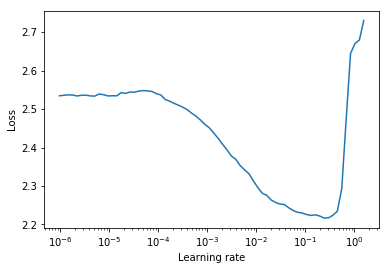

In [6]:
lr_finder.plot()

To restore the model and optimizer to their initial state use the `reset()` method.

In [7]:
lr_finder.reset()

## Validation loss (Leslie N. Smith)

If a dataloader is passed to `LRFinder.range_test()` through the `val_loader` parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

This version of the learning rate range test is described in [Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith](https://arxiv.org/abs/1506.01186).

In [8]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **evaluation** loss.

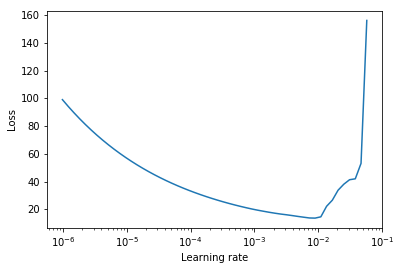

In [9]:
lr_finder.plot(skip_end=0)

To restore the model and optimizer to their initial state use the `reset()` method.

In [10]:
lr_finder.reset()